In [1]:
import os

import pymupdf
import tabula

from tqdm import tqdm
import base64

import fitz

import io
from IPython.display import display, Image

from IPython.display import display, Markdown

In [165]:
os.getcwd()

'/Users/christian.horvat@fhnw.ch/Documents/2D_3D/la-chose/literature/02_EFH RW_1-50'

In [2]:
def display_page_in_notebook(page, zoom=2.0, dpi=300):
    """
    Display a PyMuPDF page in a Jupyter notebook.
    
    Parameters:
    -----------
    page : fitz.Page
        The PyMuPDF page object to display
    zoom : float, optional
        Zoom factor for rendering the page (default: 2.0)
    dpi : int, optional
        DPI for rendering the page (default: 300)
        
    Returns:
    --------
    None
        The page is displayed directly in the notebook
    """
    # Get the page dimensions
    rect = page.rect
    
    # Calculate the pixel dimensions based on zoom and DPI
    width = int(rect.width * zoom)
    height = int(rect.height * zoom)
    
    # Create a pixmap with alpha channel
    # Use RGB color space (without alpha) for better performance
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), alpha=False)
    
    # Convert pixmap to PNG image data
    img_data = pix.tobytes("png")
    
    # Display the image in the notebook
    display(Image(data=img_data))

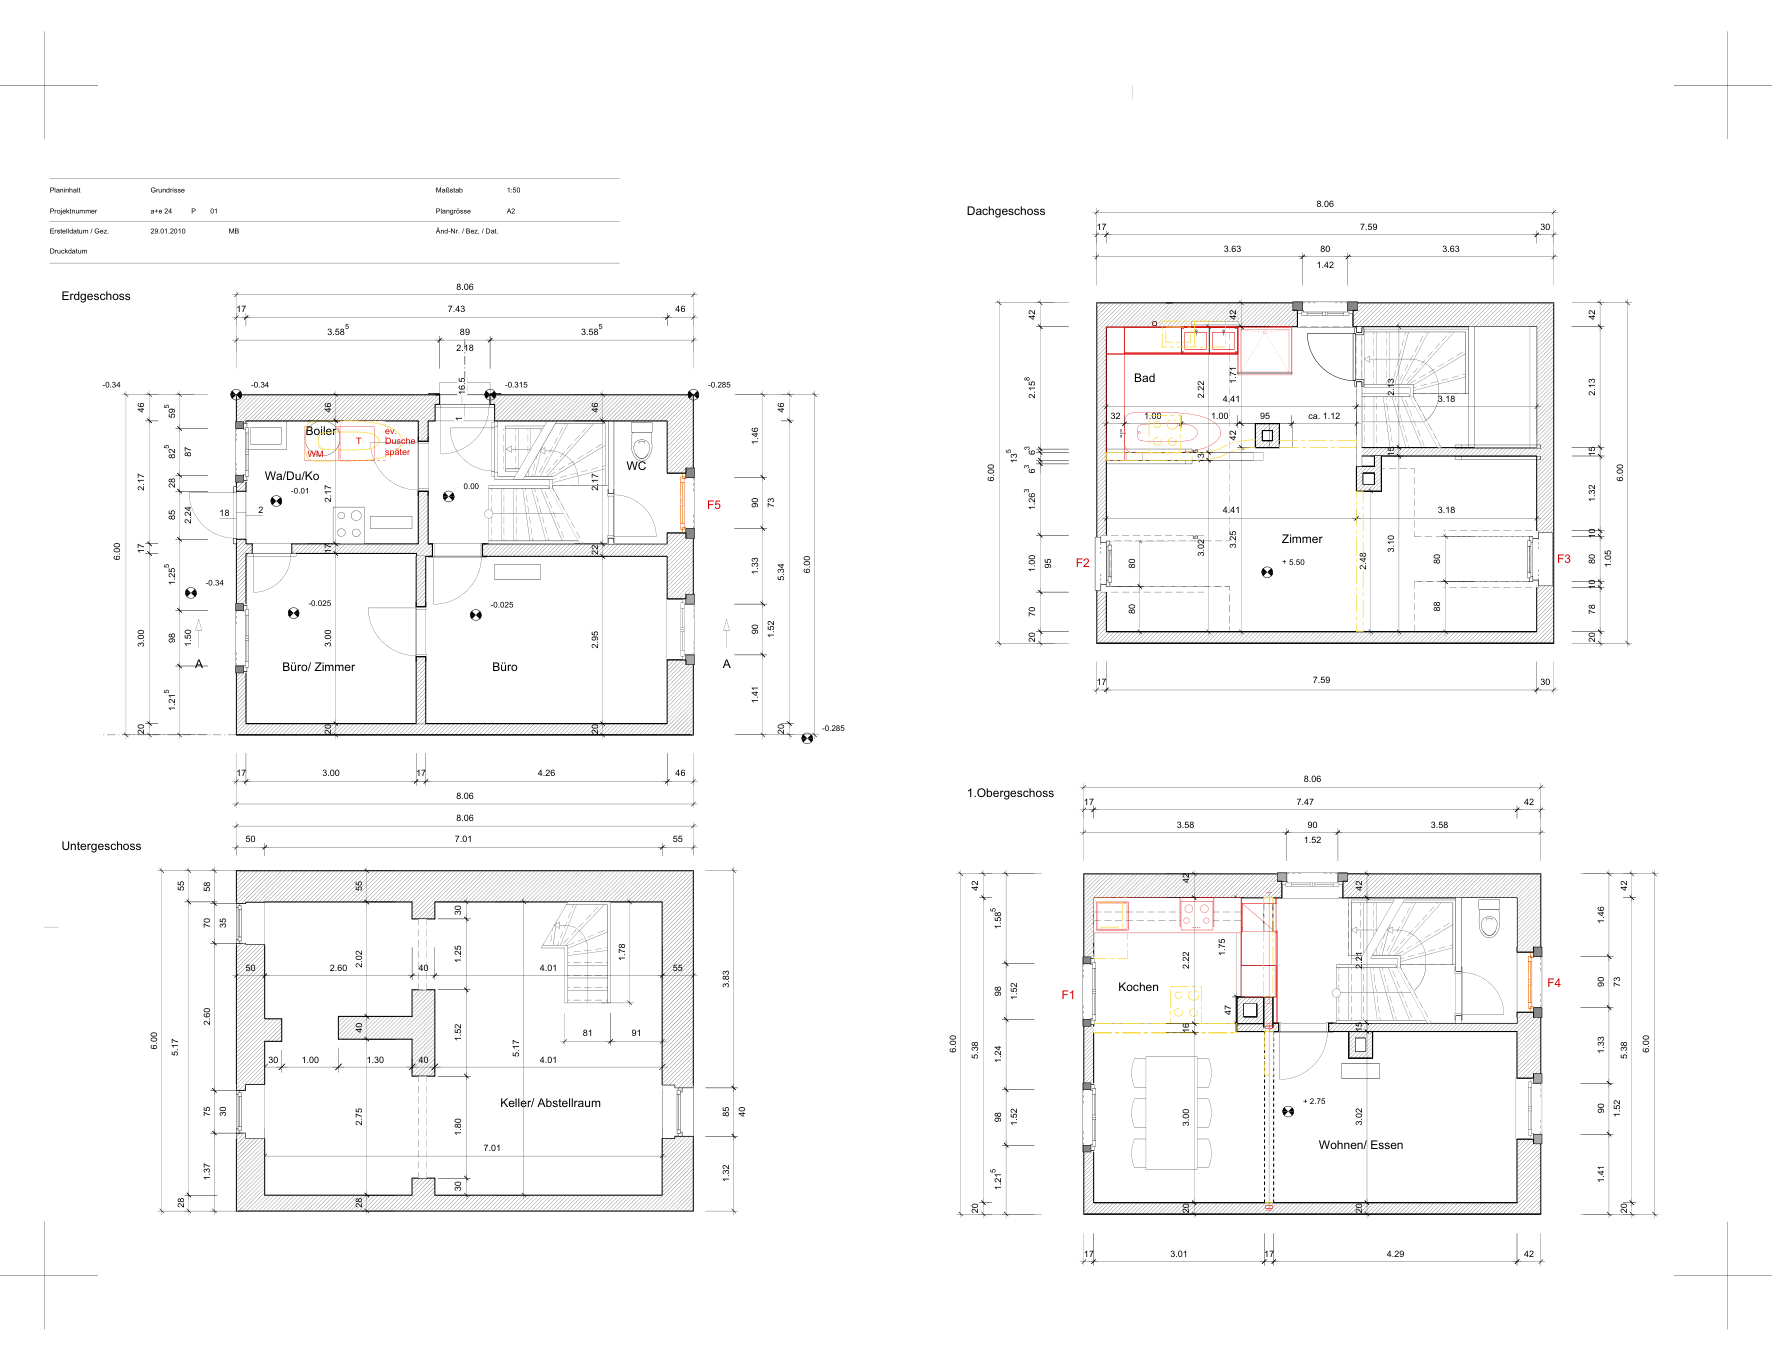

In [5]:
filename = "Rheinweilerweg Bestand.pdf"
base_dir = "/data/02_EFH RW_1-50"
filepath = os.path.join(base_dir, filename)
doc = fitz.open(filename)

page = doc[0]
display_page_in_notebook(page, zoom=1.0)
    

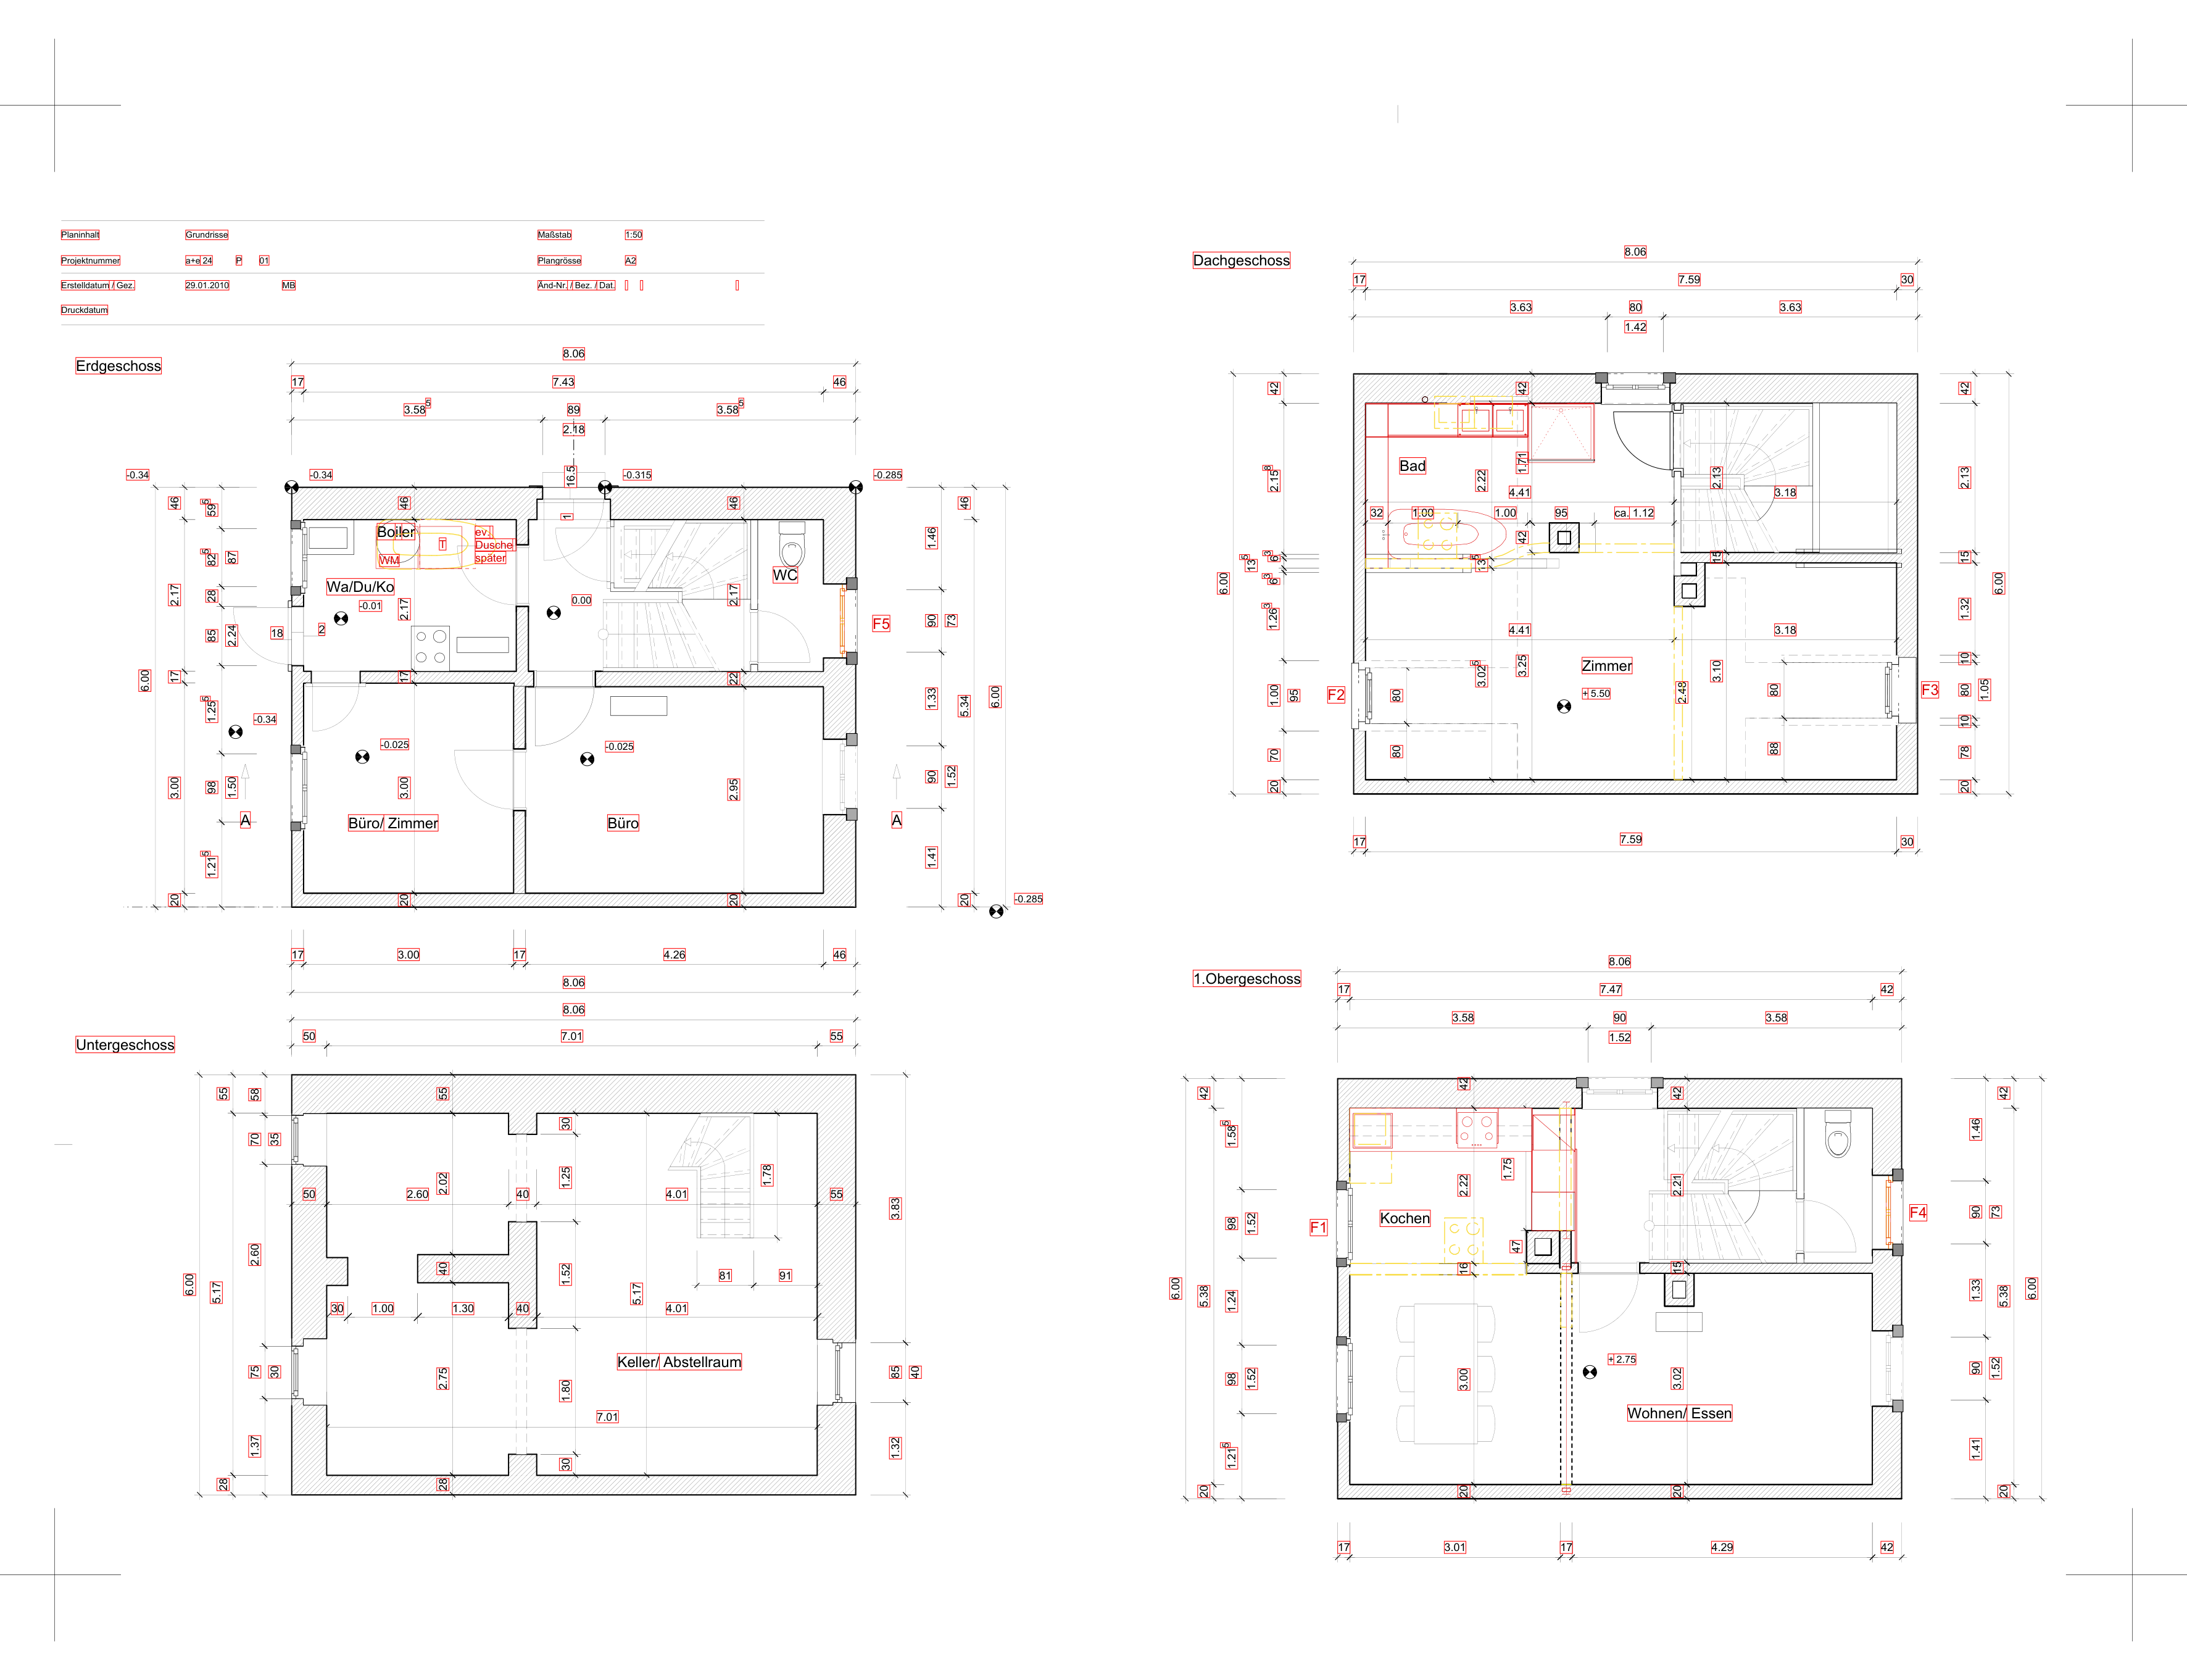

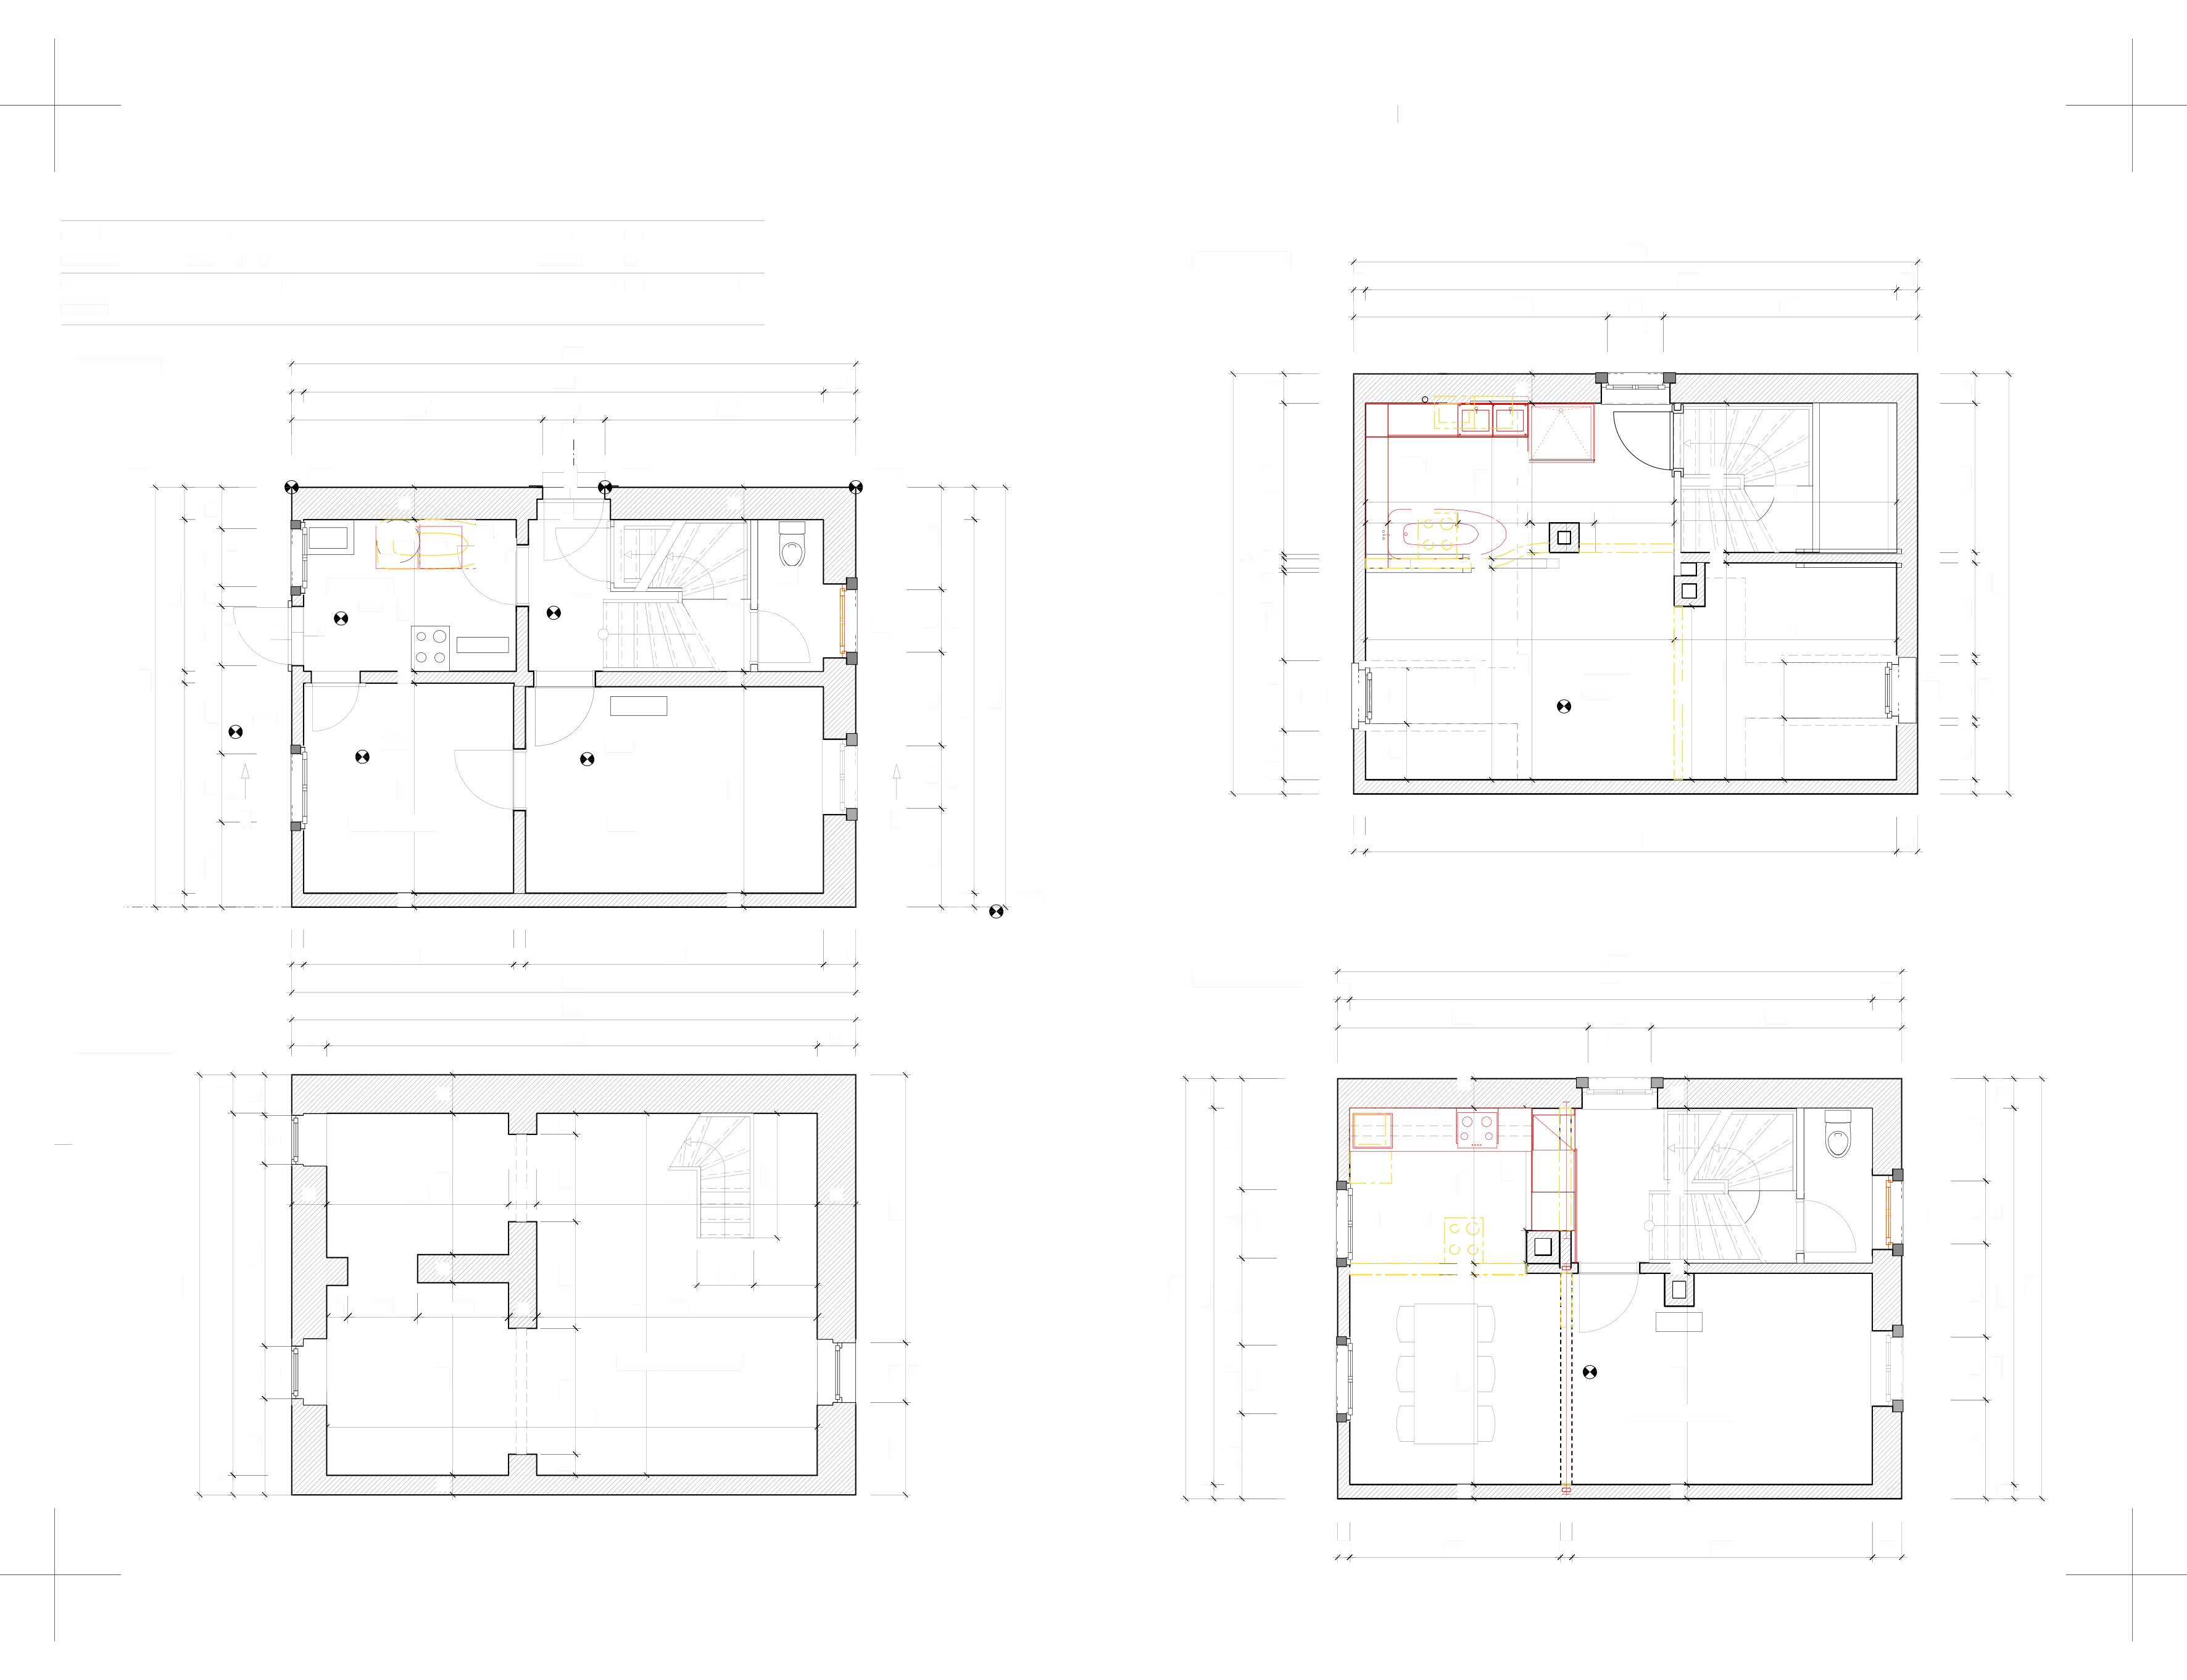

In [6]:
# PyMuPDF
def highlight_text_elements(page, delete_text=False, box_color=(1, 0, 0), box_width=0.5):
    """
    Draw bounding boxes around text elements on a PyMuPDF page.
    
    Parameters:
    -----------
    page : fitz.Page
        The PyMuPDF page object to process
    delete_text : bool, optional
        If True, removes the text content but keeps the page layout
    box_color : tuple, optional
        RGB color tuple for the bounding boxes (values from 0 to 1)
    box_width : float, optional
        Width of the bounding box lines
        
    Returns:
    --------
    fitz.Page
        The processed page with bounding boxes (and possibly deleted text)
    """
    # Get text blocks from the page
    text_blocks = page.get_text("dict")["blocks"]
    
    # Create a new shape object for drawing
    shape = page.new_shape()
    
    # Process all text blocks
    for block in text_blocks:
        # Check if the block contains text
        if "lines" in block:
            for line in block["lines"]:
                for span in line["spans"]:
                    # Get the bounding box of the span
                    rect = fitz.Rect(span["bbox"])
                    
                    # Draw a rectangle around the text
                    shape.draw_rect(rect)
                    
                    # If delete_text is True, remove the text by drawing a white rectangle
                    if delete_text:
                        # Create a white fill to cover the text
                        shape.draw_rect(rect)
                        shape.finish(fill=(1, 1, 1), color=(1, 1, 1))
    
    # Commit the shapes to the page with specified color and line width
    shape.finish(width=box_width, color=box_color)
    shape.commit()
    
    return page, text_blocks


# Open a PDF document
# doc = fitz.open("example.pdf")

# Get a page (0-based index)
# page = doc[0]

# Option 1: Just highlight text elements
highlighted_page, text_blocks = highlight_text_elements(page)
display_page_in_notebook(highlighted_page, zoom=2.0)
    
page_without_text, text_blocks = highlight_text_elements(page, delete_text=True)
display_page_in_notebook(page_without_text, zoom=2.0)

# Save the result to a new PDF
doc.save("page_without_text.pdf")


In [7]:
filename = "page_without_text.pdf"
# base_dir = "/data/02_EFH RW_1-50"
filepath = os.path.join(os.getcwd(), filename)
doc = fitz.open(filepath)

page_without_text = doc[0]
# display_page_in_notebook(page, zoom=2.0)

paths = page_without_text.get_drawings()

# for path in paths:
#     print(path["width"])
# page_without_strong_lines = page_without_text

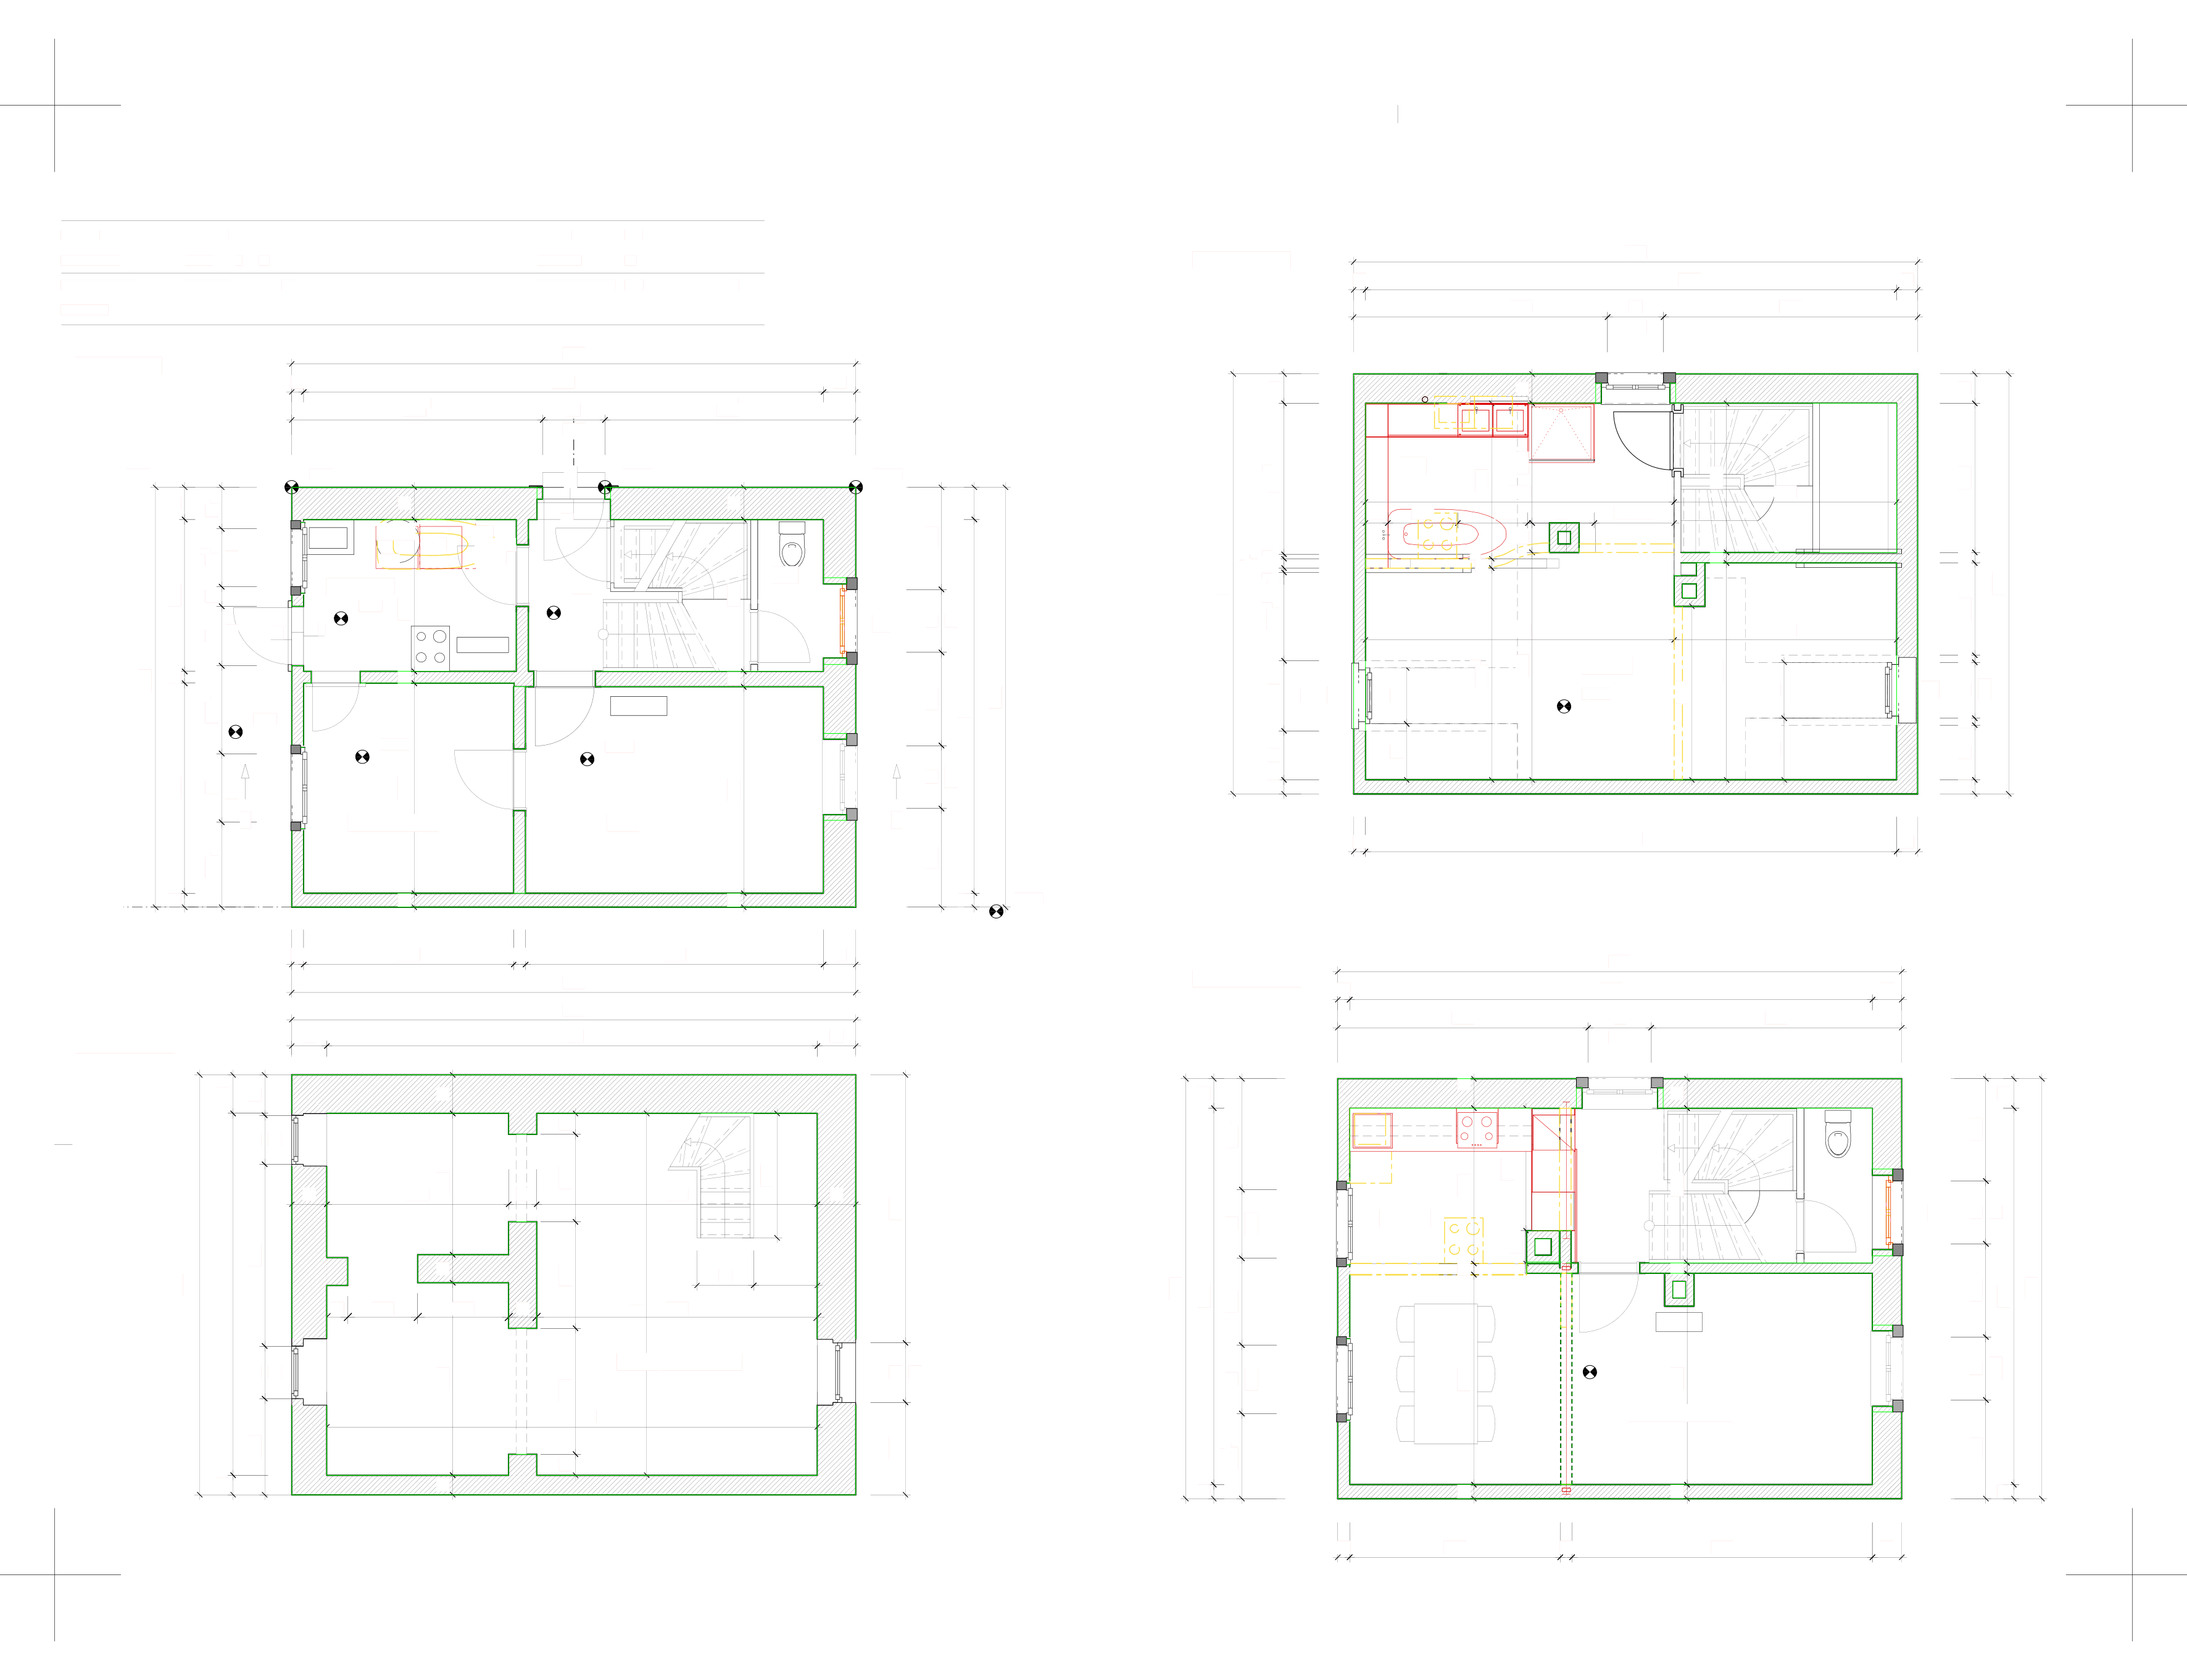

In [8]:
# Create a new shape object for drawing
box_width = 0.5
box_color = 'green'

shape = page_without_text.new_shape()
walls = []
for path in paths:
    width = path["width"]
    stroke_opacity = path["stroke_opacity"]
    if width is not None:
        if width>1.0 and stroke_opacity==1.0:
            rect = path["rect"]
            walls += [rect]
            shape.draw_rect(rect)
              
# Commit the shapes to the page with specified color and line width
shape.finish(width=box_width, color=(0, 1, 0))
shape.commit()  

display_page_in_notebook(page_without_text, zoom=2.0)
# Save the result to a new PDF
# doc.save("highlighted_text.pdf")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def detect_interior_exterior(page, rects, scale=1.0, gap_size=3):
    """
    Determines interior vs exterior space using directional flooding (light-ray method)
    with gap closing to prevent water flowing through small openings
    
    Parameters:
    - page: Dictionary with 'width' and 'height' properties
    - rects: List of PyMuPDF Rect objects in format (x0, y0, x1, y1)
    - scale: Optional scaling factor to reduce grid size for large pages
    - gap_size: Maximum size of gaps to close (in pixels)
    
    Returns:
    - Dictionary with grid and visualization methods
    """
    # Scale down dimensions if needed
    width = int(page.rect.width * scale)
    height = int(page.rect.height * scale)
    
    # Create a grid representation of the page (0 = empty, 1 = boundary)
    grid = np.zeros((height, width), dtype=int)
    
    # Mark all rectangle boundaries on the grid
    for rect in rects:
        # Extract coordinates from PyMuPDF Rect format (x0, y0, x1, y1)
        if isinstance(rect, tuple) and len(rect) == 4:
            x0, y0, x1, y1 = rect
        else:
            # Try to extract as object attributes if not a tuple
            x0, y0 = rect.x0, rect.y0
            x1, y1 = rect.x1, rect.y1
        
        # Scale coordinates
        x0, y0 = int(x0 * scale), int(y0 * scale)
        x1, y1 = int(x1 * scale), int(y1 * scale)
        
        # Ensure width and height are at least 1 pixel
        if x0 == x1:
            x1 += 1
        if y0 == y1:
            y1 += 1
        
        # Clip to grid bounds
        x0 = max(0, min(x0, width-1))
        y0 = max(0, min(y0, height-1))
        x1 = max(0, min(x1, width-1))
        y1 = max(0, min(y1, height-1))
        
        # Mark the perimeter of the rectangle
        # Top and bottom edges
        for i in range(x0, x1+1):
            if 0 <= i < width:
                if 0 <= y0 < height:
                    grid[y0, i] = 1
                if 0 <= y1 < height:
                    grid[y1, i] = 1
        
        # Left and right edges
        for j in range(y0, y1+1):
            if 0 <= j < height:
                if 0 <= x0 < width:
                    grid[j, x0] = 1
                if 0 <= x1 < width:
                    grid[j, x1] = 1
    
    # Close small gaps between boundaries (horizontal direction)
    grid_with_gaps_closed = close_gaps(grid, gap_size)
    
    # Perform directional flooding from each direction using the grid with gaps closed
    south_to_north = flood_south_to_north(grid_with_gaps_closed, width, height)
    north_to_south = flood_north_to_south(grid_with_gaps_closed, width, height)
    west_to_east = flood_west_to_east(grid_with_gaps_closed, width, height)
    east_to_west = flood_east_to_west(grid_with_gaps_closed, width, height)
    
    # Combine results (water from ANY direction is exterior, otherwise interior)
    # 0 = exterior (water), 1 = boundary, 2 = interior
    result = np.zeros((height, width), dtype=int)
    
    # First mark all boundaries
    result[grid_with_gaps_closed == 1] = 1
    
    # Areas that are flooded from ANY direction are exterior
    exterior_mask = (
        south_to_north | 
        north_to_south | 
        west_to_east | 
        east_to_west
    )
    # Areas that are not boundaries and not exterior are interior
    interior_mask = (grid == 0) & (~exterior_mask)
    
    result[exterior_mask] = 0  # Exterior
    result[interior_mask] = 2  # Interior
    
    return {
        'grid': result,
        'boundaries': grid,
        'boundaries_with_gaps_closed': grid_with_gaps_closed,
        'floods': {
            'south_to_north': south_to_north,
            'north_to_south': north_to_south,
            'west_to_east': west_to_east,
            'east_to_west': east_to_west
        }
    }

def flood_south_to_north(grid, width, height):
    """
    Flood from south to north (bottom to top)
    Water starts at the bottom row and moves upward
    Water is blocked by boundaries
    
    Returns:
    - Boolean array where True = water (exterior)
    """
    # Create a result array (True = water/exterior)
    result = np.zeros((height, width), dtype=bool)
    
    # Start with the bottom row completely filled with water
    result[height-1, :] = True
    
    # Propagate water upwards row by row
    for y in range(height-2, -1, -1):  # Start from second-to-last row, move up
        for x in range(width):
            # If there's no boundary here and the pixel below has water
            if grid[y, x] == 0 and result[y+1, x]:
                result[y, x] = True
    
    return result

def flood_north_to_south(grid, width, height):
    """
    Flood from north to south (top to bottom)
    Water starts at the top row and moves downward
    Water is blocked by boundaries
    
    Returns:
    - Boolean array where True = water (exterior)
    """
    # Create a result array (True = water/exterior)
    result = np.zeros((height, width), dtype=bool)
    
    # Start with the top row completely filled with water
    result[0, :] = True
    
    # Propagate water downwards row by row
    for y in range(1, height):  # Start from second row, move down
        for x in range(width):
            # If there's no boundary here and the pixel above has water
            if grid[y, x] == 0 and result[y-1, x]:
                result[y, x] = True
    
    return result

def flood_west_to_east(grid, width, height):
    """
    Flood from west to east (left to right)
    Water starts at the leftmost column and moves right
    Water is blocked by boundaries
    
    Returns:
    - Boolean array where True = water (exterior)
    """
    # Create a result array (True = water/exterior)
    result = np.zeros((height, width), dtype=bool)
    
    # Start with the leftmost column completely filled with water
    result[:, 0] = True
    
    # Propagate water rightwards column by column
    for x in range(1, width):  # Start from second column, move right
        for y in range(height):
            # If there's no boundary here and the pixel to the left has water
            if grid[y, x] == 0 and result[y, x-1]:
                result[y, x] = True
    
    return result

def flood_east_to_west(grid, width, height):
    """
    Flood from east to west (right to left)
    Water starts at the rightmost column and moves left
    Water is blocked by boundaries
    
    Returns:
    - Boolean array where True = water (exterior)
    """
    # Create a result array (True = water/exterior)
    result = np.zeros((height, width), dtype=bool)
    
    # Start with the rightmost column completely filled with water
    result[:, width-1] = True
    
    # Propagate water leftwards column by column
    for x in range(width-2, -1, -1):  # Start from second-to-last column, move left
        for y in range(height):
            # If there's no boundary here and the pixel to the right has water
            if grid[y, x] == 0 and result[y, x+1]:
                result[y, x] = True
    
    return result

def visualize_result(detection_result, page, scale=1.0, show_original_boundaries=False):
    """
    Visualize the interior/exterior detection results
    
    Parameters:
    - detection_result: Result from detect_interior_exterior
    - page: Dictionary with 'width' and 'height' properties
    - scale: Same scaling factor used in detection
    - show_original_boundaries: If True, show original boundaries instead of closed ones
    
    Returns:
    - matplotlib figure
    """
    width = int(page['width'] * scale)
    height = int(page['height'] * scale)
    grid = detection_result['grid']
    
    # For visualization, we might want to show the original boundaries
    if show_original_boundaries:
        # Create a copy of grid and replace boundary markings with original boundaries
        temp_grid = grid.copy()
        temp_grid[temp_grid == 1] = 0  # Clear current boundaries
        temp_grid[detection_result['boundaries'] == 1] = 1  # Use original boundaries
        grid = temp_grid
    
    # Create a colormap for visualization (0=exterior, 1=boundary, 2=interior)
    colors = np.zeros((height, width, 3))
    
    for y in range(height):
        for x in range(width):
            if grid[y, x] == 1:  # Boundary
                colors[y, x] = [0, 0, 0]  # Black
            elif grid[y, x] == 0:  # Exterior (water)
                colors[y, x] = [0.8, 0.8, 0.8]  # Light gray
            else:  # Interior
                colors[y, x] = [0.2, 0.6, 1.0]  # Blue
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(colors, origin='upper')
    ax.set_title('Interior vs Exterior Detection')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Add a legend
    legend_elements = [
        Rectangle((0, 0), 1, 1, color='black', label='Boundary'),
        Rectangle((0, 0), 1, 1, color=[0.8, 0.8, 0.8], label='Exterior'),
        Rectangle((0, 0), 1, 1, color=[0.2, 0.6, 1.0], label='Interior')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    return fig

# Function to visualize results from individual directions
def close_gaps(grid, gap_size=100):
    """
    Close small gaps between boundaries
    
    Parameters:
    - grid: 2D numpy array with boundaries marked as 1
    - gap_size: Maximum size of gaps to close (in pixels)
    
    Returns:
    - 2D numpy array with gaps closed
    """
    height, width = grid.shape
    result = grid.copy()
    
    # Close horizontal gaps
    for y in range(height):
        x = 0
        while x < width:
            if grid[y, x] == 1:  # Found a boundary
                # Look for the next boundary in this row
                start_x = x
                x += 1
                while x < width and grid[y, x] == 0:
                    x += 1
                
                # If found another boundary within gap_size, fill the gap
                if x < width and grid[y, x] == 1 and x - start_x <= gap_size + 1:
                    result[y, start_x:x+1] = 1
            else:
                x += 1
    
    # Close vertical gaps
    for x in range(width):
        y = 0
        while y < height:
            if grid[y, x] == 1:  # Found a boundary
                # Look for the next boundary in this column
                start_y = y
                y += 1
                while y < height and grid[y, x] == 0:
                    y += 1
                
                # If found another boundary within gap_size, fill the gap
                if y < height and grid[y, x] == 1 and y - start_y <= gap_size + 1:
                    result[start_y:y+1, x] = 1
            else:
                y += 1
    
    return result

def visualize_individual_floods(detection_result, page, scale=1.0):
    """
    Visualize the flooding from each direction
    
    Parameters:
    - detection_result: Result from detect_interior_exterior
    - page: Dictionary with 'width' and 'height' properties
    - scale: Same scaling factor used in detection
    
    Returns:
    - matplotlib figure
    """
    width = int(page['width'] * scale)
    height = int(page['height'] * scale)
    boundaries = detection_result['boundaries_with_gaps_closed']
    floods = detection_result['floods']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    titles = ['South to North', 'North to South', 'West to East', 'East to West']
    flood_keys = ['south_to_north', 'north_to_south', 'west_to_east', 'east_to_west']
    
    for i, (title, key) in enumerate(zip(titles, flood_keys)):
        ax = axs[i//2, i%2]
        
        # Create visualization with boundaries and water
        colors = np.zeros((height, width, 3))
        
        # Mark boundaries in black
        for y in range(height):
            for x in range(width):
                if boundaries[y, x] == 1:  # Boundary
                    colors[y, x] = [0, 0, 0]  # Black
                elif floods[key][y, x]:  # Water
                    colors[y, x] = [0, 0.5, 1.0]  # Blue for water
                else:  # Dry
                    colors[y, x] = [1.0, 0.9, 0.7]  # Beige for dry areas
        
        ax.imshow(colors, origin='upper')
        ax.set_title(f'Flooding: {title}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plt.tight_layout()
    return fig



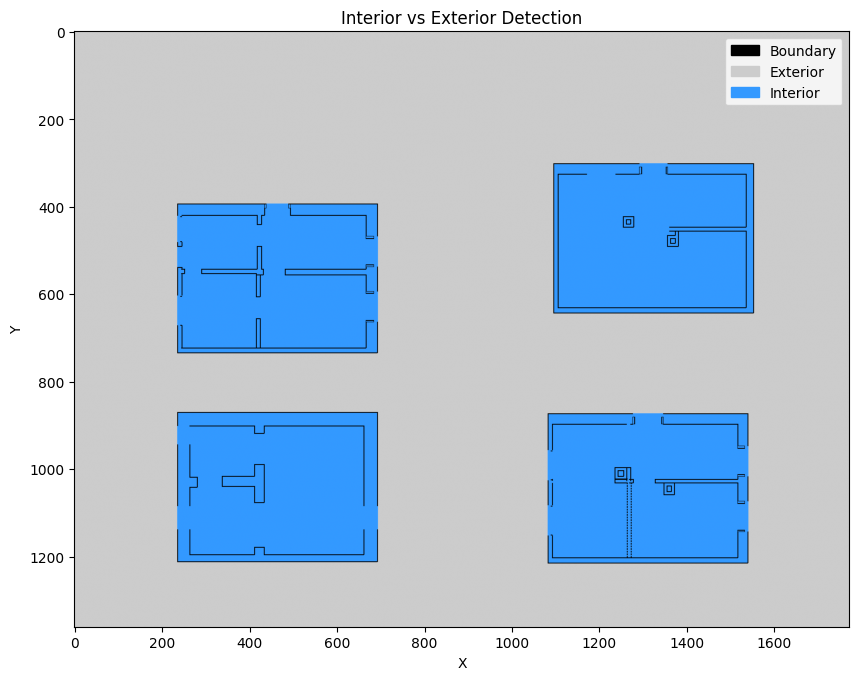

In [169]:
result = detect_interior_exterior(page_without_text,walls, gap_size=100)
fig = visualize_result(result, {'width': page.rect.width, 'height': page.rect.height}, scale=1.0)
plt.show()

In [172]:
import fitz  # PyMuPDF
from PIL import Image
import io
import numpy as np
from scipy.ndimage import zoom

def erase_interior_content(page_obj, detection_result, scale, output_pdf_path=None, dpi=300):
    """
    Erases all content except in the exterior regions of a PDF page.
    
    Parameters:
    - page_obj: PyMuPDF page object
    - detection_result: Result dictionary from detect_interior_exterior
    - scale: Same scaling factor used in detection
    - output_pdf_path: Path to save the modified PDF (if None, only modifies the page in memory)
    - dpi: Resolution for page rendering (higher = better quality but larger file)
    
    Returns:
    - None, but modifies the page_obj and optionally saves to file
    """
    # Render the page to an image
    pix = page_obj.get_pixmap(dpi=dpi)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img_np = np.array(img)
    
    # Get the grid with exterior areas marked
    grid = detection_result['grid']
    
    # Resize the grid to match the rendered image dimensions
    zoom_x = img_np.shape[1] / grid.shape[1]
    zoom_y = img_np.shape[0] / grid.shape[0]
    grid_resized = zoom(grid, (zoom_y, zoom_x), order=0)  # Nearest-neighbor interpolation
    
    # Create a mask where exterior = True, others = False
    mask = (grid_resized == 0)  # 0 = exterior in our grid
    
    # Apply the mask - set non-exterior pixels to white
    white_img = np.ones_like(img_np) * 255  # White background
    
    # Copy only the exterior pixels from the original image
    white_img[mask] = img_np[mask]
    
    # Convert to PIL Image
    img_masked = Image.fromarray(white_img)
    
    # Convert PIL Image to bytes
    img_bytes = io.BytesIO()
    img_masked.save(img_bytes, format='PNG')
    img_bytes.seek(0)
    
    # Get document and page number
    pdf = page_obj.parent
    page_num = page_obj.number
    
    # Save original page dimensions
    page_rect = page_obj.rect
    
    # Delete original page content
    page_obj.clean_contents()
    
    # Insert the masked image
    page_obj.insert_image(page_rect, stream=img_bytes.getvalue())
    
    # Save if requested
    if output_pdf_path:
        pdf.save(output_pdf_path)

filename = "Rheinweilerweg Bestand.pdf"
base_dir = os.getcwd()
filepath = os.path.join(base_dir, filename)
doc = fitz.open(filepath)

page = doc[0]
erase_interior_content(page,result,1.0,output_pdf_path=os.path.join(base_dir,'exterior.pdf'))

In [173]:
page

page 0 of /Users/christian.horvat@fhnw.ch/Documents/2D_3D/la-chose/literature/02_EFH RW_1-50/Rheinweilerweg Bestand.pdf

In [174]:
images = page.get_images()

In [175]:
images

[(101, 0, 7384, 5671, 8, 'DeviceRGB', '', 'fzImg0', '')]

In [181]:
# process images
def process_images(page, page_num, base_dir, items):
    images = page.get_images()
    for idx, image in enumerate(images):
        xref = image[0]
        pix = pymupdf.Pixmap(doc, xref)
        if not pix.colorspace.name in (pymupdf.csGRAY.name, pymupdf.csRGB.name):
            pix = pymupdf.Pixmap(pymupdf.csRGB, pix)
        image_name = f"{base_dir}/images/{os.path.basename(filepath)}_image_{page_num}_{idx}_{xref}.png"
        pix.save(image_name)
        with open(image_name, 'rb') as f:
            encoded_image = base64.b64encode(f.read()).decode('utf8')
        items.append({"page": page_num, "type": "image", "path": image_name, "image": encoded_image})

items = []
process_images(page, 1, os.getcwd(), items)

In [178]:
images[0].get_pixmap(dpi=150)

AttributeError: 'tuple' object has no attribute 'get_pixmap'

In [184]:
# Process page images
def process_page_images(page, page_num, base_dir, items):
    pix = page.get_pixmap()
    page_path = os.path.join(base_dir, f"page_images/page_{page_num:03d}.png")
    pix.save(page_path)
    with open(page_path, 'rb') as f:
        page_image = base64.b64encode(f.read()).decode('utf8')
    items.append({"page": page_num, "type": "page", "path": page_path, "image": page_image})
items = []
process_page_images(page, 1, os.getcwd(), items)